# Time Series: Trend Detection (Urban Degreening)

# Introduction

When we assemble and examine time series we are looking to observe some difference between a measurment at time 1 and the same measurment at time 2. From this data we can derive the trend of the data, patterns in the variation such as seasonality and more.

We can easily see how this works with an example of a time series of NDVI derived from Landsat 4-8 over the last 40 years! With a series this long we should be able to see patterns in the data and extract an overall trend or slope of the data.

In urban centers we often notice development and expansion. We've seen how land use change can be obvious in remotely sensed images in previous labs. In this lab we will walk through a case study for the neighbourhoods in the City of Ottawa, where average NDVI is calculated for each neighborhood over an entire summer for every year of data that we have, using mosaics. We will check out a number of ways to view and interpret the resulting NDVI time series.

# Imports and Initialization

Let's set up our document by installing the necessary libraries and importing packages we will use.

In [25]:
#!pip install geemap
# !pip install geopandas
# !pip install rasterstats
# !pip install scipy
# !pip install pyCRS

import ee
import pycrs
import geemap
import os
import colour
import math
import glob
import altair
import pprint

import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from rasterstats import zonal_stats
from scipy.stats import theilslopes

# from google.colab import files
# from google.colab import drive

Next we're going to mount our drive and then upload a file from our computer onto the drive.

**Before running this code block, make sure you have downloaded the Ottawa_Neigborhoods' zip file. Unzip it and put it in an accessible location on your computer.**

When prompted, select "Choose Files" and browse to the location of the files. Select all 'Ottawa_Neighborhood' files that were in the zip folder.

In [26]:
# drive.mount('/content/drive')

In [27]:
ee.Authenticate()
ee.Initialize(project='ee-cptcitrus-main') # make sure you change this to your project

## Set map and geometry

In [4]:
# Open shapefile as ee object
shp = 'C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/data/OttawaNeighbourhoods/OttawaNeighbourhoods/Ottawa_Neighbourhoods.shp'
ONS = geemap.shp_to_ee(shp)

# Convert object to feature collection
ONS_fc = ee.FeatureCollection(ONS)

# Select one neighbourhood and convert fc to geometry
aoi = ONS_fc  # To select all neighbourhoods
aoiName = "Ottawa"
geometry = ONS_fc.geometry()

Map = geemap.Map()
Map.addLayer(geometry)
Map.centerObject(geometry,10)
Map

Map(center=[45.28925318473928, -75.77194574270555], controls=(WidgetControl(options=['position', 'transparent_…

## Define functions

These functions perform various tasks which help us set up our images for mosaicking. As we are dealing with several Landsat collections, we also have to make some conversions to get suitable band combinations for direct comparison.

It is not important that you know exactly how these functions work, as long as you can identify what the function does. In coding we can often find functions that other people have created and shared. It is unnessecary to always write your own functions if they exist elsewhere (but you should always credit the original creator).

In [28]:
# Changes band names to include the year the image was acquired
def renameBandsreduced(image, bandnames, year):
    bandnames_l = bandnames.getInfo()
    date = '_'+str(year)
    new_bands = []
    for i in bandnames_l:
        new = i[:-5]
        new_bands.append(new)
    return image.select(bandnames).rename(new_bands).copyProperties(image, ["system:time_start"])

# Converts NDVI band math to float
def L8_to_L7(image):
    ndvi = image.select('NDVI')

    # Roy et al.:  '-0.0110 + 0.9690 * ndvi'

    # For Ottawa:
    expr ='0.94213 * ndvi + 0.02107'

    X = image.expression(expr, {'ndvi': ndvi}).rename('ndvi_corr')
    image = image.addBands([X])
    image = image.select('ndvi_corr').rename('NDVI')
    #return image.cast({'NDVI' : ee.PixelType('float',-1,1)})
    return image.toFloat()

# Create a mosaic with an image collection, provided the percentile, year, and AOI
def mosaic(imagecoll,percentile,year,geometry):
  # Use images from June-August in study area
  startdate = str(year)+"-06-01"
  enddate = str(year)+"-08-31"
  coll = imagecoll.filter(ee.Filter.Or(
                  ee.Filter.And(ee.Filter.date(startdate,enddate)))) \
                  .filterBounds(geometry)
  # Mosaic the images based on percentile
  mosaic = coll.reduce(ee.Reducer.percentile([percentile]))#.clip(geometry)
  # Rename the reduced bands
  bn = mosaic.bandNames()
  mosaic_renamed = renameBandsreduced(mosaic, bn, year)
  # Add year as image property
  mosaic_w_properties = ee.Image(mosaic_renamed.set({'date': year}))
  # Return mosaic
  return mosaic_w_properties

# Function to mask clouds in Landsat images
def cloudMask(image):
  # Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5
  # Get the pixel QA band.
  qa = image.select('QA_PIXEL')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
      .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  # Return the masked image, with the QA bands.
  return image.updateMask(mask)

# Define functions to rename bands to compare between L457 and L8
def renameBandsL457(image):
    bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL']
    new_bands = ['B', 'G', 'R', 'NIR', 'SWIR1', 'SWIR2', 'QA_PIXEL']
    return image.select(bands).rename(new_bands)

# Rename bands in Landsat 8
def renameBandsL8(image):
    bands = ['SR_B1','SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL']
    new_bands = ['CB','B', 'G', 'R', 'NIR', 'SWIR1', 'SWIR2', 'QA_PIXEL']
    image = image.select(bands).rename(new_bands)
    return image

# Calculate NDVI
def calcNDVI(image):
  nir = image.select('NIR')
  red = image.select('R')
  ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
  image = image.addBands(ndvi)
  return image.select('NDVI')

# Create annual mosaics

We are going to create mosiacs for each year of interest. This will require importing images from several Landsat collections to cover our period of interest (1984 to 2022).

## Create image collections

Here we import Landsat 4, 5, 7, and 8 collections into ImageCollection objects, ready for use.

In [29]:
L4_SR_T1 = ee.ImageCollection('LANDSAT/LT04/C02/T1_L2')
L5_SR_T1 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
L7_SR_T1 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
L8_SR_T1 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

## Define mosaic functions

There are a couple more functions we need to use to create all of these mosaics efficiently.

In [30]:
# Define a function to transfer feature properties to a dictionary.
# We use this to convert our earth engine object (reduced image collection) to a
# collection of properties and their values
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')
  return ee.Dictionary.fromLists(prop_names, prop_lists)

# Define function to reduce mosaic by regions
def regional_df(image,geometry,year):
  fc = image.reduceRegions(
      collection = geometry,
      reducer= ee.Reducer.mean(),
      scale= 30)
  fcdict = fc_to_dict(fc).getInfo()
  df = pd.DataFrame(fcdict)
  df = df[['Name','mean']]
  df.rename({'mean':'NDVI'}, axis='columns',inplace=True)
  df['Year']=str(year)
  return df

We are going to run this analysis with and without Landsat-8 data.  First we will do a case study in which we do not use Landsat-8.  We will also do a case study where we include Landsat-8 as well.

## Case study in which we DO NOT use L8 data

Run these subsections of code to generate data for L4, L5 & L7 but not L8.

We are running this lab twice: once with L8 and once without L8 data. The Landsat 8 collection contains the most current images because L8 is a currently operational satellite and the others have been retired.

We are comparing the trends we detect when looking at the period covered by only L4 to L7, and the trends we detect when looking at the period covered by L4 through L8 (current) because there has been a significant amount of change since the implementation of L8.

**Skip the L8 case study section and carry on to the analysis section to generate the results for this test.**

In [31]:
# Filter image collections by aoi
l4coll =  ee.ImageCollection(L4_SR_T1)\
                .filterBounds(aoi)\
                .map(cloudMask)\
                .map(renameBandsL457)\
                .map(calcNDVI)
l5coll =  ee.ImageCollection(L5_SR_T1)\
                .filterBounds(aoi)\
                .map(cloudMask)\
                .map(renameBandsL457)\
                .map(calcNDVI)
l7coll =  ee.ImageCollection(L7_SR_T1)\
                .filterBounds(aoi)\
                .map(cloudMask)\
                .map(renameBandsL457)\
                .map(calcNDVI)

# Merge collections together to create one large img collection
L457 = l4coll.merge(l5coll).merge(l7coll)

In [9]:
test = L457.first()
bounds = aoi.union()
bounds = ee.Feature(bounds)
# bounds = bounds.geometry()

In [10]:
coordinates = [
    [-76.20, 45.50],  # Northwest corner
    [-75.20, 45.50],  # Northeast corner
    [-75.20, 44.95],  # Southeast corner
    [-76.20, 44.95],  # Southwest corner
    [-76.20, 45.50]   # Closing the loop back to the first point
]

# Create a polygon feature using the coordinates
ottawa_bbox = ee.Geometry.Polygon([coordinates])


In [13]:
geemap.ee_export_image(test, filename='C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/data/OttawaNeighbourhoods/OttawaNeighbourhoods/landsat_image.tif', scale=30, region=ottawa_bbox, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\cptci\OneDrive - Carleton University\Documents\GitHub\GEOG6006-qb\data\OttawaNeighbourhoods\OttawaNeighbourhoods\landsat_image.tif


In [11]:
# geemap.ee_export_image_to_drive(
#     image=test,
#     description='landsat_image',
#     folder='gee',
#     fileNamePrefix='landsat_image',
#     region=ottawa_bbox,
#     scale=30,
#     crs='EPSG:4326',
#     maxPixels=1e13
# )

In [46]:
# ee.data.listOperations()

[{'name': 'projects/ee-cptcitrus-main/operations/AZGW7IIQO3GTCWLFZUZNBI33',
  'metadata': {'@type': 'type.googleapis.com/google.earthengine.v1alpha.OperationMetadata',
   'state': 'SUCCEEDED',
   'description': 'landsat_image',
   'priority': 100,
   'createTime': '2024-10-08T17:10:54.897616Z',
   'updateTime': '2024-10-08T17:13:09.718244Z',
   'startTime': '2024-10-08T17:11:02.214447Z',
   'endTime': '2024-10-08T17:13:09.718244Z',
   'type': 'EXPORT_IMAGE',
   'destinationUris': ['https://drive.google.com/#folders/1-36Uy6Wn8UguDTy1ipBvKGeWGMQn35Ia'],
   'attempt': 1,
   'progress': 1,
   'stages': [{'displayName': 'Create Local Files',
     'completeWorkUnits': 1,
     'totalWorkUnits': '1',
     'description': 'Computation and writing of temporary files.'},
    {'displayName': 'Write Files to Destination',
     'completeWorkUnits': 1,
     'totalWorkUnits': '1',
     'description': 'Uploading of files to the export destination.'}],
   'batchEecuUsageSeconds': 11.727104187011719},
  '

In [47]:
# ee.data.getTaskStatus("AZGW7IIQO3GTCWLFZUZNBI33")

[{'state': 'COMPLETED',
  'description': 'landsat_image',
  'priority': 100,
  'creation_timestamp_ms': 1728407454897,
  'update_timestamp_ms': 1728407589718,
  'start_timestamp_ms': 1728407462214,
  'task_type': 'EXPORT_IMAGE',
  'destination_uris': ['https://drive.google.com/#folders/1-36Uy6Wn8UguDTy1ipBvKGeWGMQn35Ia'],
  'attempt': 1,
  'batch_eecu_usage_seconds': 11.727104187011719,
  'id': 'AZGW7IIQO3GTCWLFZUZNBI33',
  'name': 'projects/ee-cptcitrus-main/operations/AZGW7IIQO3GTCWLFZUZNBI33'}]

### Summarize mosaics into dataframe

Use the following cells to create the dataframe and export it to a csv.

**Note: this could take 30 minutes to 1 hour to run. You'll be updated about the progress in the output below the code block.**

If you have already created the dataframe in another instance and exported it to csv you can skip to Analyze Results.

**Note: you will have to do this once for the L457 dataframe and again (below) for the L4578 dataframe because they contain different information.**

In [11]:
df_list = []
img_list = ee.List([])

for year in range (1984,2022):
  size = L457.filter(ee.Filter.Or(ee.Filter.And(ee.Filter.date(str(year)+"-06-01",str(year)+"-08-31")))).size().getInfo()
  if size > 1:
    mosaick = mosaic(L457,100,year,geometry)
    img_list = img_list.add(mosaick)

    df = regional_df(mosaick,ONS_fc,year)
    df_list.append(df)

    print("Done mosaicking the {} images from {}".format(size,year))
  else:
    print("{} only has {} image(s) so it cannot be mosaicked.".format(year,size))


Done mosaicking the 19 images from 1984
Done mosaicking the 22 images from 1985
Done mosaicking the 16 images from 1986
Done mosaicking the 21 images from 1987
Done mosaicking the 17 images from 1988
Done mosaicking the 20 images from 1989
Done mosaicking the 17 images from 1990
Done mosaicking the 18 images from 1991
Done mosaicking the 15 images from 1992
Done mosaicking the 17 images from 1993
Done mosaicking the 19 images from 1994
Done mosaicking the 20 images from 1995
Done mosaicking the 21 images from 1996
Done mosaicking the 11 images from 1997
Done mosaicking the 10 images from 1998
Done mosaicking the 32 images from 1999
Done mosaicking the 31 images from 2000
Done mosaicking the 39 images from 2001
Done mosaicking the 37 images from 2002
Done mosaicking the 31 images from 2003
Done mosaicking the 40 images from 2004
Done mosaicking the 39 images from 2005
Done mosaicking the 38 images from 2006
Done mosaicking the 35 images from 2007
Done mosaicking the 41 images from 2008


KeyboardInterrupt: 

In [ ]:
# Combine the df_list into a long format dataframe
df_long = pd.concat(df_list)
df_long

### Export the dataframe to csv

We can export our results to save them so that we don't have to run that computationally expensive process again.

In [ ]:
# Export the dataframe to csv
df_long.to_csv('C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/data/OttawaNeighbourhoods/OttawaNeighbourhoods/df_long_19842020_SR_mean_L457.csv', index=False)

### OR import the dataframe from csv

If you've already run the process, you can import your results using this code block.

,Name,NDVI,Year
0,Old Barrhaven West,0.342632,1984
1,Beacon Hill South - Cardinal Heights,0.265639,1984
2,Beaverbrook,0.319628,1984
3,Bells Corners East,0.290550,1984
4,Bells Corners West,0.295508,1984
...,...,...,...
4213,Fallingbrook,0.249999,2021
4214,Cardinal Creek,0.354067,2021
4215,Riverview,0.251978,2021
4216,Manor Park,0.278033,2021


### **Once you've completed the L457 example, skip to** *Analyze Results*

### **Come back here to start the L4578 example**

## Case study in which we DO use L8 data

Come back here after you've run the analysis section for the L457 dataframe.

Run these code blocks to redefine the dataframe and include L8.

In [12]:
# Filter image collections by aoi
l4coll =  ee.ImageCollection(L4_SR_T1)\
                .filterBounds(aoi)\
                .map(cloudMask)\
                .map(renameBandsL457)\
                .map(calcNDVI)
l5coll =  ee.ImageCollection(L5_SR_T1)\
                .filterBounds(aoi)\
                .map(cloudMask)\
                .map(renameBandsL457)\
                .map(calcNDVI)
l7coll =  ee.ImageCollection(L7_SR_T1)\
                .filterBounds(aoi)\
                .map(cloudMask)\
                .map(renameBandsL457)\
                .map(calcNDVI)
l8coll =  ee.ImageCollection(L8_SR_T1)\
                .filterBounds(aoi)\
                .map(cloudMask)\
                .map(renameBandsL8)\
                .map(calcNDVI)

# Convert L8 NDVI to match L7, as per Roy et al. 2016
l8coll_corr = l8coll.map(L8_to_L7)

# Merge collections together to create one large img collection
L4578 = l8coll_corr.merge(l4coll).merge(l5coll).merge(l7coll)

Here's a method to check how many images are available from each year (this can be useful information for interpretation later!).

**Note: you do not *need* to run the code block below. It will take around 1 hour if you do.**

In [13]:
# print("L4, L5, L7, L8")

# years= range(1984,2021)
# for year in years:
#   size4 = l4coll.filter(ee.Filter.Or(ee.Filter.And(ee.Filter.date(str(year)+"-06-01",str(year)+"-08-31")))).size().getInfo()
#   size5 = l5coll.filter(ee.Filter.Or(ee.Filter.And(ee.Filter.date(str(year)+"-06-01",str(year)+"-08-31")))).size().getInfo()
#   size7 = l7coll.filter(ee.Filter.Or(ee.Filter.And(ee.Filter.date(str(year)+"-06-01",str(year)+"-08-31")))).size().getInfo()
#   size8 = l8coll.filter(ee.Filter.Or(ee.Filter.And(ee.Filter.date(str(year)+"-06-01",str(year)+"-08-31")))).size().getInfo()
#   print("Year ", year, ": ", size4, " ", size5, " ", size7, " ", size8)

### Summarize mosaics into dataframe

Use the following cells to create the dataframe for L4578 and export it to a csv.

**Note: this could take up to an hour to run. You'll be updated about the progress in the output below the code block.**

If you have already created the dataframe in another instance and exported it to csv you can skip to Analyze Results.

In [14]:
df_list = []
img_list = ee.List([])

for year in range (1984,2022):
  size = L4578.filter(ee.Filter.Or(ee.Filter.And(ee.Filter.date(str(year)+"-06-01",str(year)+"-08-31")))).size().getInfo()
  if size > 1:
    mosaick = mosaic(L4578,100,year,geometry)
    img_list = img_list.add(mosaick)

    df = regional_df(mosaick,ONS_fc,year)
    df_list.append(df)

    print("Done mosaicking the {} images from {}".format(size,year))
  else:
    print("{} only has {} image(s) so it cannot be mosaicked.".format(year,size))


Done mosaicking the 19 images from 1984
Done mosaicking the 22 images from 1985
Done mosaicking the 16 images from 1986
Done mosaicking the 21 images from 1987
Done mosaicking the 17 images from 1988
Done mosaicking the 20 images from 1989
Done mosaicking the 17 images from 1990
Done mosaicking the 18 images from 1991
Done mosaicking the 15 images from 1992
Done mosaicking the 17 images from 1993
Done mosaicking the 19 images from 1994
Done mosaicking the 20 images from 1995
Done mosaicking the 21 images from 1996
Done mosaicking the 11 images from 1997
Done mosaicking the 10 images from 1998
Done mosaicking the 32 images from 1999
Done mosaicking the 31 images from 2000
Done mosaicking the 39 images from 2001
Done mosaicking the 37 images from 2002
Done mosaicking the 31 images from 2003
Done mosaicking the 40 images from 2004
Done mosaicking the 39 images from 2005
Done mosaicking the 38 images from 2006
Done mosaicking the 35 images from 2007
Done mosaicking the 41 images from 2008


In [15]:
# Combine the df_list into a long format dataframe
df_long = pd.concat(df_list)
df_long

,Name,NDVI,Year
0,Old Barrhaven West,0.342632,1984
1,Beacon Hill South - Cardinal Heights,0.265639,1984
2,Beaverbrook,0.319628,1984
3,Bells Corners East,0.290550,1984
4,Bells Corners West,0.295508,1984
...,...,...,...
106,Fallingbrook,0.274713,2021
107,Cardinal Creek,0.373424,2021
108,Riverview,0.284886,2021
109,Manor Park,0.299829,2021


### Export the dataframe to csv

We can export our results to save them so that we don't have to run that computationally expensive process again.

In [16]:
# Export the dataframe to csv
df_long.to_csv('C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/data/OttawaNeighbourhoods/OttawaNeighbourhoods/df_long_19842020_SR_mean_L4578.csv', index=False)

### OR import the dataframe from csv

If you've already run the process, you can import your results using this code block.

In [17]:
# Import the dataframe from csv
df_long = pd.read_csv('C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/data/OttawaNeighbourhoods/OttawaNeighbourhoods/df_long_19842020_SR_mean_L4578.csv')
df_long

,Name,NDVI,Year
0,Old Barrhaven West,0.342632,1984
1,Beacon Hill South - Cardinal Heights,0.265639,1984
2,Beaverbrook,0.319628,1984
3,Bells Corners East,0.290550,1984
4,Bells Corners West,0.295508,1984
...,...,...,...
4213,Fallingbrook,0.274713,2021
4214,Cardinal Creek,0.373424,2021
4215,Riverview,0.284886,2021
4216,Manor Park,0.299829,2021


# Analyze Results

We're going to produce some time series plots to help us visualize and analyze the results.

In [8]:
#L457
df_long = pd.read_csv('C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/GEOG6006-qb/data/data for lab 7/df_long_19842020_SR_mean_L457_cloudMasked.csv')

In [16]:
#L4578
df_long = pd.read_csv('C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/GEOG6006-qb/data/data for lab 7/df_long_19842020_SR_mean_L4578.csv')

### Create a simple plot

This will create a simple plot with all of our data so that we can visualize the time series.

<Axes: title={'center': 'NDVI Change in Ottawa Neighbourhoods'}, xlabel='Year', ylabel='NDVI'>

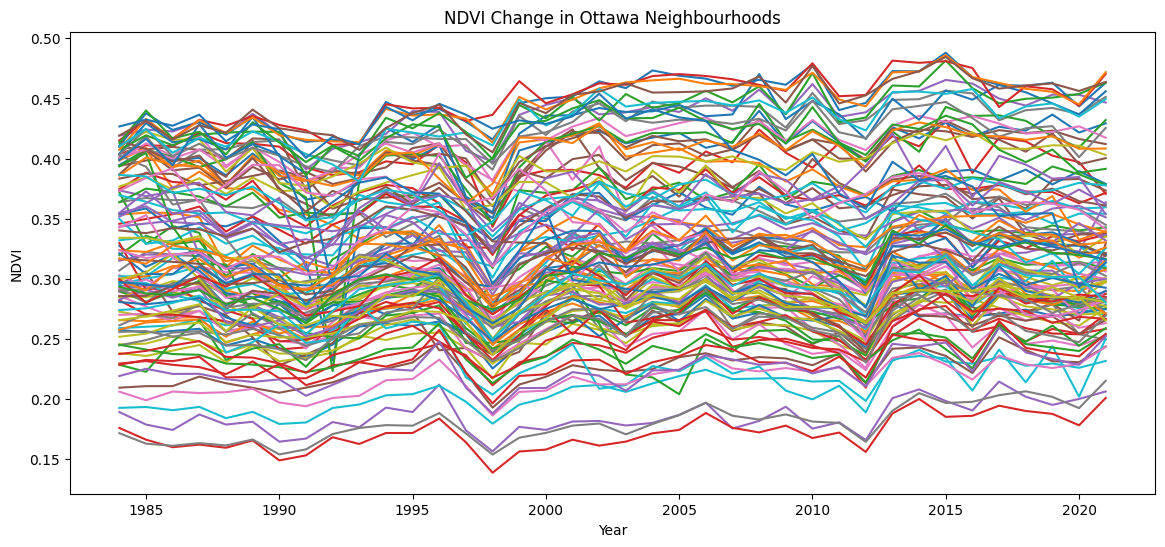

In [17]:
# convert the long format df to a wide format df
df = df_long.pivot_table(index='Name',
                    columns='Year',
                    values='NDVI')

# transpose it so that plot() recognizes its format properly
df = df.transpose()

# plot it
df.plot(title = 'NDVI Change in Ottawa Neighbourhoods',
        xlabel = 'Year',
        ylabel='NDVI',
        figsize=(14, 6),
        legend = False)

### Create an interactive plot

This code block will generate an interactive plot so that we can more easily interpret the time series. We have a large amount of data, which can become hard to distinguish with only different colours/patterns, so an interactive plot is beneficial.

Note: for this we are using the long format dataframe because it uses a column to group the data (in this case, neighbourhood name), unlike the previous method which plotted each row.

In [18]:
import altair as alt

# Set the highlight parameters
# When we hover our mouse over a point, we want all the points that share that year
# to be highlighted
highlight = alt.selection(
    type='single', on='mouseover', fields=['Year'], nearest=True)

# Set the base, this is the same as above.
base = alt.Chart(df_long).encode(
    x=alt.X('Year:Q', scale=alt.Scale(domain=[1982,2020]),axis = alt.Axis(format='.0f')),
    y=alt.Y('NDVI:Q', scale=alt.Scale(domain=[0.3,0.9])),
    color=alt.Color('Name:O', scale=alt.Scale(scheme='turbo'),legend=None)).properties(
    title='NDVI Change in Ottawa Neighbourhoods')

# Add points - change the size based on the highlight condition we set above
points = base.mark_circle().encode(
    size=alt.condition(~highlight, alt.value(10), alt.value(15)),
    tooltip=[
        alt.Tooltip('Name:O', title='Neighbourhood'),
        alt.Tooltip('Year:Q', title='Year'),
        alt.Tooltip('NDVI:Q', title='Median NDVI')
    ]).add_selection(highlight)

# Add lines - change the size based on the highlight condition
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(4)))

# Set the chart properties and add .interactive()
(points + lines).properties(width=800, height=450).interactive()

alt.LayerChart(...)

### Calculate slopes and compare

Here we are going to do some simple math to calculate the slopes of the trend lines for each neighborhood. The Theil-Sen slope can help us classify trends in univariate time series.

Calculate Theil-Sen slope of NDVI for each neighbourhood and identify the average trend for the region, as well as the most and least changed neighbourhoods. This is a simple way to interpret where the most and least change has occured when we have such a large amount of data.

In [19]:
# Create lists to iterate through with the neighbourhood names and years
# In our dataframe, the neighbourhoods are the row names (index) and the years are the columns
names = list(df.columns)
years = list(df.index)

names

['Bayshore - Belltown',
 'Beacon Hill South - Cardinal Heights',
 'Beaverbrook',
 'Beechwood Cemetery',
 'Bells Corners East',
 'Bells Corners West',
 'Billings Bridge - Alta Vista',
 'Blackburn Hamlet',
 'Borden Farm - Fisher Glen',
 'Braemar Park - Bel Air Heights - Copeland Park',
 'Briar Green - Leslie Park',
 'Bridlewood - Emerald Meadows',
 'Britannia Village',
 "Brookside - Briarbrook - Morgan's Grant",
 'Byward Market',
 'Cardinal Creek',
 'Carleton Heights - Rideauview',
 'Carleton University',
 'Carlington',
 'Carlingwood West - Glabar Park - McKellar Heights',
 'Carp',
 'Carson Grove - Carson Meadows',
 'Centrepointe',
 'Centretown',
 'Chapel Hill North',
 'Chapel Hill South',
 'Chapman Mills',
 'Chatelaine Village',
 'Cityview - Crestview - Meadowlands',
 'Civic Hospital-Central Park',
 'Constance Bay',
 'Convent Glen - Orléans Woods',
 'Corkery',
 'Crystal Bay - Lakeview Park',
 'Cumberland',
 'Dunrobin',
 'East Industrial',
 'Edwards - Carlsbad Springs',
 'Elmvale - Cante

Mean slope for entire region is: 0.0002909588004166192
Chapman Mills has experienced the greatest decrease in NDVI
Wateridge Village has experienced the greatest increase in NDVI


<Axes: xlabel='Year'>

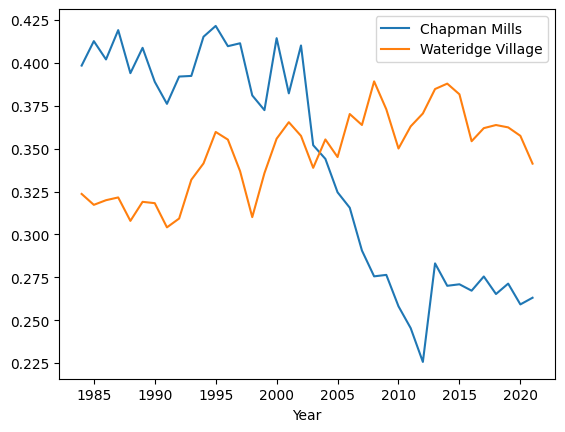

In [20]:
# Calculate the slopes, across the entire time period, using Theil-Sen regression
slopes = []
for name in names:
    years = [int(i) for i in years]
    data = df[name].tolist()
    slopes.append(theilslopes(data, years, 0.90)[0])

# Turn it into a data frame
dfSlopes = pd.DataFrame(slopes, names)
dfSlopes.columns = ['slope']

# Mean slope for entire region
meanSlope = dfSlopes['slope'].mean()
print("Mean slope for entire region is: " + str(meanSlope))

# Neighbourhood with minimum slope
minIndex = dfSlopes['slope'].idxmin(axis=0, skipna=True)
print(minIndex + " has experienced the greatest decrease in NDVI")
minNeighbourhood = df[minIndex]

# Neighbourhood with maximum slope
maxIndex = dfSlopes['slope'].idxmax(axis=0, skipna=True)
print(maxIndex + " has experienced the greatest increase in NDVI")
maxNeighbourhood = df[maxIndex]

# Plotting those two together
dfMinMax = pd.concat([minNeighbourhood, maxNeighbourhood], axis=1)
dfMinMax.plot()



In [21]:
#find OOS
dfSlopesOOS = df['Old Ottawa South']

You can create plots for any neighbourhood you are specifically interested in. If you want to see a list of all of them go check out the [Ottawa Neighbourhood Study](https://www.neighbourhoodstudy.ca/).

Chapman Mills has experienced the greatest decrease in NDVI
Wateridge Village has experienced the greatest increase in NDVI


<Axes: xlabel='Year'>

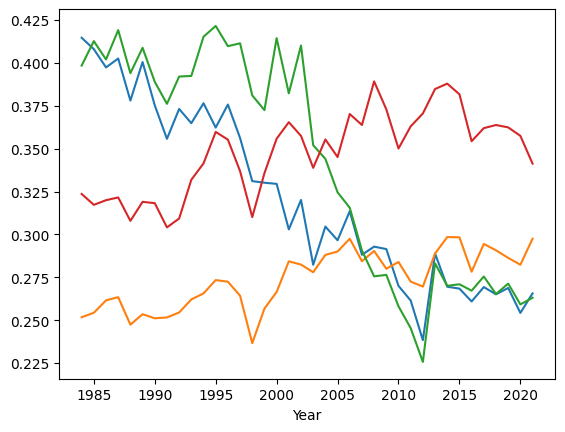

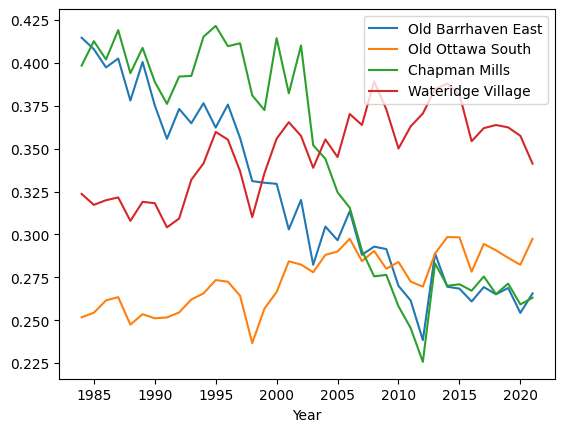

In [22]:
# Plot Barrhaven. This plot makes sense because Barrhaven was expanded betweenbetween 1984 and 1989,
# after which is has just matured
Barrhaven = df['Old Barrhaven East']
Barrhaven.plot()

# Plot Ottawa South. Not sure this plot makes as much sense, though the trend is relatively consistent actually.
OttawaSouth = df['Old Ottawa South']
OttawaSouth.plot()

# Neighbourhood with minimum slope
minIndex = dfSlopes['slope'].idxmin(axis=0, skipna=True)
print(minIndex + " has experienced the greatest decrease in NDVI")
minNeighbourhood = df[minIndex]
minNeighbourhood.plot()

# Neighbourhood with maximum slope
maxIndex = dfSlopes['slope'].idxmax(axis=0, skipna=True)
print(maxIndex + " has experienced the greatest increase in NDVI")
maxNeighbourhood = df[maxIndex]
maxNeighbourhood.plot()

# Plotting those two together
dfMinMax = pd.concat([Barrhaven, OttawaSouth, minNeighbourhood, maxNeighbourhood], axis=1)
dfMinMax.plot()

### Plot the extreme neighborhoods
To have a quick look at the most extreme neighbourhoods, we can sort the data frame by slopes, and plot the five neighbourhoods with the largest/smallest slopes on their own plots.

<Axes: xlabel='Year'>

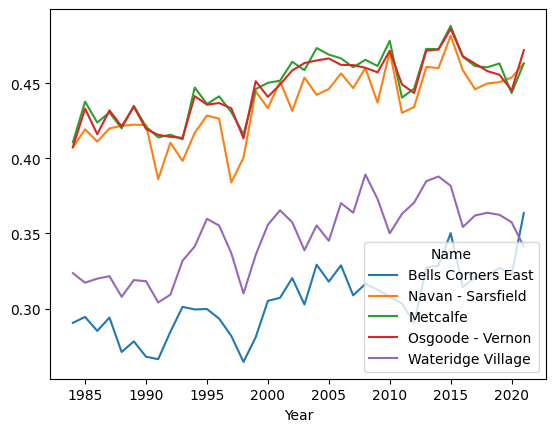

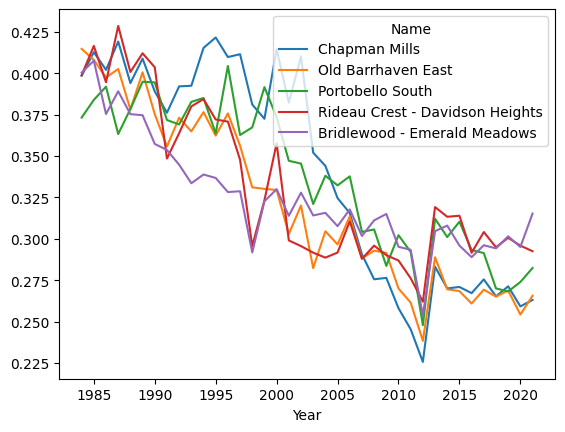

In [23]:
df_sorted = dfSlopes.sort_values(by=['slope'])

most_increasing_neighbourhoods = df_sorted.tail(5).index.values
most_decreasing_neighbourhoods = df_sorted.head(5).index.values

df_most_increasing = df[most_increasing_neighbourhoods]
df_most_increasing.plot()

df_most_decreasing = df[most_decreasing_neighbourhoods]
df_most_decreasing.plot()

# Questions

Answer the following questions in the space provided. Feel free to add additional code and text cells as needed. Make sure to show all of your code.

**In all cases**, if you use code chunks from another source (not a bad thing), make sure to reference where you found them.

## Q1

To get a visual understanding of what has caused the neighbourhoods with the greatest decrease in NDVI to lose vegetation cover, find them on the [Ottawa Neighbourhood Study website](https://www.neighbourhoodstudy.ca/), then take a look at them using [Google Timelapse](https://earthengine.google.com/timelapse/). Explain specifically what you see for each of these neighbourhoods.

// Your answer here

Chapman Mills - Population growth at the cost of a conservation area?????

Old Barrhaven East - Population growth from an old uban core

Portobello South - Population growth taking over agriculture

Rideau Crest - Davidson Heights - Population growth at the cost of a conservation area?????

Bridlewood - Emerald Meadows: population growth, at the cost of green space.

## Q2

Select one the neighborhoods with the greatest increase in NDVI that we identified above. Find at least two good images (one from early in our time series, and one from close to the end) where you can see the progressive changes in vegetation cover. Visualize your images on a map in a way which makes the vegetation changes as evident as possible (zoomed in to your AOI). Add some comments justifying your visualization choice(s).

In [81]:
# Your code here

# Your code here - taken from this lab and google earth engine itself
# Function to apply scaling factors
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
    return image.addBands(optical_bands, None, True)

aoi = ee.Geometry.Point([-76.07392146287515, 45.4853116856015])

L4_SR_T1 = ee.ImageCollection('LANDSAT/LT04/C02/T1_L2')
L5_SR_T1 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
L7_SR_T1 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
L8_SR_T1 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

l4coll =  L4_SR_T1.filterBounds(aoi).map(apply_scale_factors)
l5coll =  L5_SR_T1.filterBounds(aoi).map(apply_scale_factors)
l7coll =  L7_SR_T1.filterBounds(aoi).map(apply_scale_factors)
l8coll =  L8_SR_T1.filterBounds(aoi).map(apply_scale_factors)

# Merge collections together to create one large img collection
L4578 = l8coll.merge(l4coll).merge(l5coll).merge(l7coll)
L4578

L4578_early = L4578.filterBounds(aoi)\
            .filterDate('1987-06-01', '1987-08-30')\
            .sort('CLOUD_COVER')\
            .first()
L4578_late = L4578.filterBounds(aoi)\
            .filterDate('2021-06-01', '2021-08-30')\
            .sort('CLOUD_COVER')\
            .first()

# Set the visualization parameters for the image
visParamsL5 = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0.0,
    'max': 0.3,
}
visParamsL8 = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

Map = geemap.Map() # Create map object
Map.centerObject(aoi, zoom=8)
Map.addLayer(L4578_early,visParamsL5, '1987 Landsat')
Map.addLayer(L4578_late,visParamsL8, '2020 Landsat')
Map # Display the map


Map(center=[45.4853116856015, -76.07392146287515], controls=(WidgetControl(options=['position', 'transparent_b…

// Your answer here

Constance Bay has grown very little, but has actually seen some road removals in green spaces, leading to a net NDVI increase.

## Q3

We seperated our work into two case studies: L457 only (1984 - 2012) and L4578 (1984 - present).

Did you notice a difference in which neighborhoods experienced the least and most change between our two examples? Put another way: were the 10 extreme neighborhoods different depending on whether L8 was included or not?

Which ones were different?

When including the L8 data, the communities with the greatest increasing and decreasing trends change slightly. North Gower-Kars is no longer one of the greatest NDVI increasing trends, having been replaced by Bells Corner East. Greenboro East is no longer one of the strongest decreasing trends, having been replaced by Bridlewood - Emerald Meadows.


// Write your answer here

##Q4: Why do you think there were differences between the L457 only and L4578 tests? 

The increased timespan is probably responsible for the changing trends. This would correspond to growth (and conversely, stagnent growth or contraction) from 2013 to 2020.